In [1]:
import os
import pickle
import joblib
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from beach.beach import Profile
from beach.support import data_support as ds
from beach.support import classifier_support as cs

from pylab import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.simplefilter("ignore", UserWarning)

# Plotting Paramaters
params = {'legend.fontsize': 10,
           'axes.labelsize': 10,
           'axes.labelweight': 'regular',
           'axes.titlesize': 11,
           'axes.titleweight': 'regular',
           'xtick.labelsize': 10,
           'ytick.labelsize': 10,
           'mathtext.default':'regular'}
plt.rcParams.update(params)

%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# Narrabeen beach profile adjustment

The data has already been downloaded for you and consists of a .csv files (comma-separated values).
This is a commonly used data format that opens easily in a range of software programs such as Notepad, Microsoft Excel, and obviously Python.

In [2]:
# Manually define names for each column
names = [
    "Site",
    "Profile",
    "date",
    "x",
    "z",
    "Flag"
]
df = pd.read_csv('../pracenv/dataset/Narrabeen_Profiles.csv', encoding="utf8", names=names, skiprows=1)
dates = pd.to_datetime(df['date'], format = '%Y-%m-%d')

# Append a new column at the end of our iribarren values
df["time"] = dates

In [3]:
df

,Site,Profile,date,x,z,Flag,time
0,NARRA,PF4,1976-04-27,0,9.52,EMERY,1976-04-27
1,NARRA,PF4,1976-04-27,10,7.12,EMERY,1976-04-27
2,NARRA,PF4,1976-04-27,20,5.88,EMERY,1976-04-27
3,NARRA,PF4,1976-04-27,30,3.88,EMERY,1976-04-27
4,NARRA,PF4,1976-04-27,40,1.56,EMERY,1976-04-27
...,...,...,...,...,...,...,...
158583,NARRA,PF2,2019-11-27,124,-0.92,GPS,2019-11-27
158584,NARRA,PF2,2019-11-27,125,-0.95,GPS,2019-11-27
158585,NARRA,PF2,2019-11-27,126,-0.96,GPS,2019-11-27
158586,NARRA,PF2,2019-11-27,127,-0.98,GPS,2019-11-27


Mean sea level for 1966-1968 was assigned a value of 0.000m on the **Australian Height Datum** (AHD) at 30 tide gauges around the coast of the Australian continent.

## Plotting beach profiles

In [4]:
def plotProfiles(PID, start_date, end_date):

    mask = (df['time'] >= start_date) & (df['time'] <= end_date)
    df_time = df.loc[mask]

    timeval = df_time.time.unique()
    timeval = pd.to_datetime(timeval)

    profiletime = []
    for k in range(len(timeval)):
        profiletime.append(str(timeval[k].date()))
    
    MyDateFormatter = DateFormatter('%d-%b-%Y')
    fig = plt.figure(figsize=(11,4), dpi=160) 

    ax1 = plt.gca()

    ax1.plot([0, 200], [0, 0], "k--", linewidth=1)

    maxx = 0.

    for k in range(len(profiletime)):
        ids1 = np.where(np.logical_and(df_time.Profile==PID,df_time.time==profiletime[k]))[0]
        maxx = max(maxx,df_time['x'].iloc[ids1].max())
        ax1.plot(df_time['x'].iloc[ids1],df_time['z'].iloc[ids1],linewidth=2,label=profiletime[k]) 


    ax1.set_ylim(-5, 10)
    ax1.set_xlim(0, maxx)

    ax1.grid(which='major', axis='y', linestyle='--')

    ax1.set_ylabel('Elevation (AHD)')
    ax1.set_xlabel('Chainage (m)')
    ax1.legend()

    plt.title('Narrabeen-Collaroy Beach Profiles '+str(PID),fontsize=11)
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=False, ncol=5, frameon=False)
    
    return

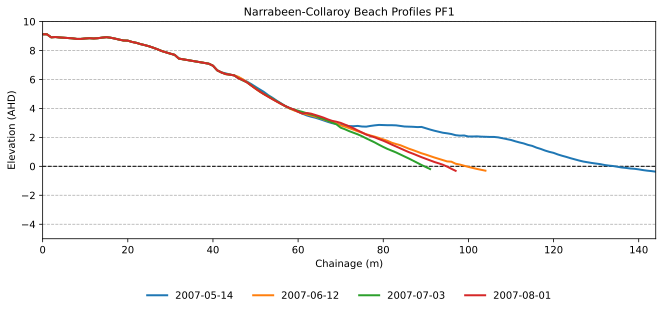

In [5]:
plotProfiles(PID='PF1', start_date = '2007-5-1', end_date = '2007-8-1')

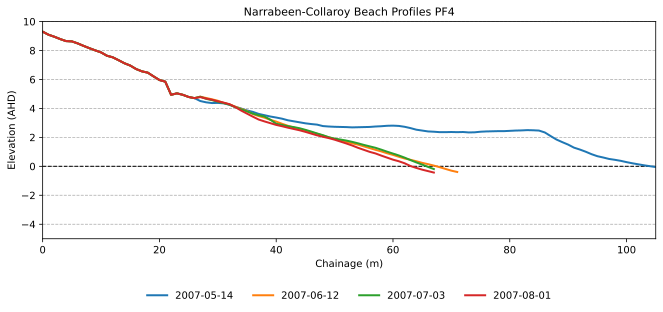

In [6]:
plotProfiles(PID='PF4', start_date = '2007-5-1', end_date = '2007-8-1')

## Extract one single profile




In [7]:
def getOneProfile(PID, date):

    mask = (df['time'] >= date) & (df['time'] <= date)
    df_time = df.loc[mask]

    timeval = df_time.time.unique()
    timeval = pd.to_datetime(timeval)

    profiletime = []
    profiletime.append(str(timeval[0].date()))
    
    MyDateFormatter = DateFormatter('%d-%b-%Y')
    fig = plt.figure(figsize=(11,4), dpi=160) 

    ax1 = plt.gca()

    ax1.plot([0, 200], [0, 0], "k--", linewidth=1)

    maxx = 0.

    ids1 = np.where(np.logical_and(df_time.Profile==PID,df_time.time==profiletime[0]))[0]
    maxx = max(maxx,df_time['x'].iloc[ids1].max())
    ax1.plot(df_time['x'].iloc[ids1],df_time['z'].iloc[ids1],linewidth=2,label=profiletime[0]) 


    ax1.set_ylim(-5, 10)
    ax1.set_xlim(0, maxx)

    ax1.grid(which='major', axis='y', linestyle='--')

    ax1.set_ylabel('Elevation (AHD)')
    ax1.set_xlabel('Chainage (m)')
    ax1.legend()

    plt.title('Narrabeen-Collaroy Beach Profiles '+str(PID),fontsize=11)
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=False, ncol=5, frameon=False)
    
    profile = pd.concat([df_time['x'].iloc[ids1], df_time['z'].iloc[ids1]], axis=1, keys=['x','z'])
    
    return profile

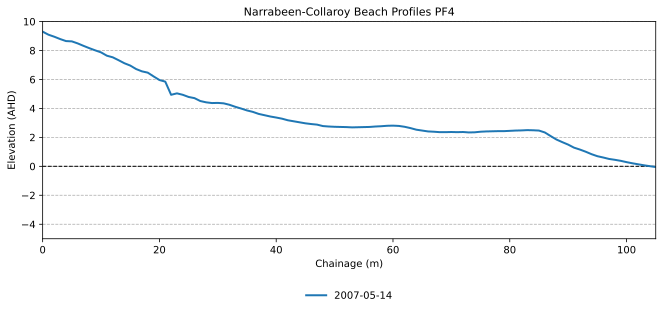

In [8]:
prof = getOneProfile(PID='PF4', date='2007-05-14')

## Locating dune toe on cross-shore beach profile transects


Based on an array of cross-shore coordinates of shape (m,) and an array of corresponding elevations of shape (m,) for a single profile. The user can then identify the location of the dune toe using the following methods:

1. **Maximum curvature** (Stockdon, Sallenger, Holman, & Howd, 2007) - the dune toe is defined as the location of maximum slope change;
2. **Relative relief** (Wernette, Houser, & Bishop, 2016) - the dune toe is defined based on relative relief (the ratio of local morphology to computational scale);
3. **Perpendicular distance** - the dune toe is defined as the point of maximum perpendicular distance from the straight line drawn between the dune crest and shoreline; and,
4. **Machine learning** using Random Forest classification


> Stockdon, H. F., Sallenger, A. H., Holman, R. A., & Howd, P. A. (2007). A simple model for the spatially-variable coastal response to hurricanes. Marine Geology, 238(1-4), 1–20. doi:10.1016/j.margeo.2006.11.004


> Wernette, P., Houser, C., & Bishop, M. P. (2016). An automated approach for extracting barrier island morphology from digital elevation models. Geomorphology, 262, 1–7. doi:10. 1016/j.geomorph.2016.02.024

In [9]:
# Profile data
x = prof['x'].to_numpy()
z = prof['z'].to_numpy()

# Instantiate
p = Profile(x, z)

### Predict dune toe location

In [10]:
toe_ml, prob_ml = p.predict_dunetoe_ml('wave_embayed_clf') # use the machine learning (ML) method
toe_mc = p.predict_dunetoe_mc() # use the maximum curvature (MC) method
toe_rr = p.predict_dunetoe_rr() # use the relative relief (RR) method
toe_pd = p.predict_dunetoe_pd() # use the perpendicular distance (PD) method

### Predict shoreline and dune crest location

In [11]:
crest = p.predict_dunecrest()
shoreline = p.predict_shoreline()

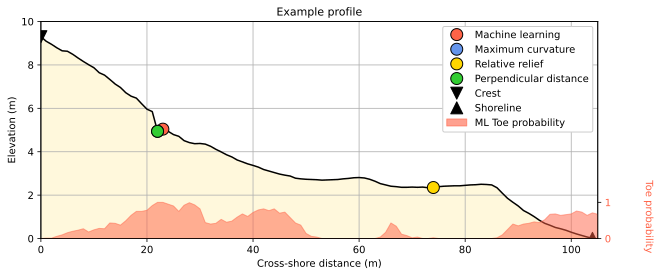

In [18]:
n=0

fig, axes = plt.subplots(1, 1, figsize=(10, 4))
toes = [toe_ml[n], toe_mc[n], toe_rr[n], toe_pd[n]]

labels = ['Machine learning', 'Maximum curvature', 'Relative relief', 'Perpendicular distance']
colors = ['tomato', 'cornflowerblue', 'gold', 'limegreen']

axes.plot(x, z, '-k')
axes.fill_between([70, 105], [0, 0], y2=-1, color='lightskyblue', alpha=0.5)
axes.fill_between(x, z, y2=-1, color='cornsilk', alpha=1)
axes.axvspan(-10, -9, color='tomato', alpha = 0.6, label='ML Toe probability') # legend placeholder
for i, itoe in enumerate(toes): 
    axes.plot(x[itoe], z[itoe],
              'o', color=colors[i], ms=12, mec='k', label=labels[i])
axes.plot(x[crest[n]], z[crest[n]], 'v', color='k', ms=12, mec='k', label='Crest')
axes.plot(x[shoreline[n]], z[shoreline[n]], '^', color='k', ms=12, mec='k', label='Shoreline')
axes.set_xlim(0, 105)
axes.set_ylim(0, 10)
axes.set_title('Example profile')
axes.set_xlabel('Cross-shore distance (m)')
axes.set_ylabel('Elevation (m)')
axes.grid()
axes.legend(framealpha=1)

# Plot dune toe ML probability
axes2 = axes.twinx() 
axes2.fill_between(x, prob_ml[n], color='tomato', alpha=0.5)
axes2.set_ylim(0, 6)
axes2.set_yticks([0, 1])
axes2.tick_params(axis='y', labelcolor='tomato')
axes2.yaxis.set_label_coords(1.1, 0.1)
axes2.set_ylabel('Toe probability', color='tomato', rotation=270);
fig.show()